In [1]:
using StatsBase, Random, LinearAlgebra, Plots, DecisionTree, DataFrames, MLDataUtils, ScikitLearn, CSV

In [49]:
data = CSV.read("raw_data.csv", DataFrame, header = true, pool = true);
first(data,10)

,Column1,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month
,Int64,String,Int64,Int64,Int64,String
1,0,Resort Hotel,0,342,2015,July
2,1,Resort Hotel,0,737,2015,July
3,2,Resort Hotel,0,7,2015,July
4,3,Resort Hotel,0,13,2015,July
5,4,Resort Hotel,0,14,2015,July
6,6,Resort Hotel,0,0,2015,July
7,7,Resort Hotel,0,9,2015,July
8,8,Resort Hotel,1,85,2015,July
9,9,Resort Hotel,1,75,2015,July


In [56]:
short_data = data[data[:,"arrival_date_year"].==2017,:];

In [15]:
names(data)

34-element Vector{String}:
 "Column1"
 "hotel"
 "is_canceled"
 "lead_time"
 "arrival_date_year"
 "arrival_date_month"
 "arrival_date_week_number"
 "arrival_date_day_of_month"
 "stays_in_weekend_nights"
 "stays_in_week_nights"
 "adults"
 "children"
 "babies"
 ⋮
 "booking_changes"
 "deposit_type"
 "agent"
 "company"
 "days_in_waiting_list"
 "customer_type"
 "adr"
 "required_car_parking_spaces"
 "total_of_special_requests"
 "reservation_status"
 "reservation_status_date"
 "occupants"

In [61]:
# Train test split by stratifying on the classifcation label y
data = short_data[:, Not([5,6,7,8,33,25,26,32])]
data = data[completecases(data), :]

# 15 is country, consider removing

X = data[:, Not([1,3])]
y = data[:, 3]
(x_train, y_train), (x_test, y_test) = IAI.split_data(:classification, X, y,
                                                      seed=1);

In [62]:
size(X)

(31615, 24)

In [63]:
# Q2.b Gini tree with Grid Search over different max depths
max_depth = 8
depths = [1:max_depth;]


auc_vec = zeros(length(depths))
acc_vec = zeros(length(depths))
cp_vec = zeros(length(depths))

for i in 1:max_depth
    
    tree_gini = IAI.OptimalTreeClassifier(
        random_seed=1,
        criterion = :gini,
        max_depth = depths[i],
        minbucket = 5,
        max_categoric_levels_before_warning=100,)
    
    grid_ginib = IAI.GridSearch(tree_gini)
    
    IAI.fit_cv!(grid_ginib, x_train, y_train, n_folds = 5, validation_criterion = :auc)
    
    tree_gini = IAI.get_learner(grid_ginib)
    
    tree_gini_params = IAI.get_params(tree_gini)
    
    
    auc = IAI.score(grid_ginib,x_test, y_test, criterion=:auc)
    acc = IAI.score(grid_ginib,x_test, y_test, criterion=:accuracy,positive_label =1)
    
    cp = tree_gini_params[:cp]
    cp = tree_gini.cp
    
    auc_vec[i] = auc
    acc_vec[i] = acc
    cp_vec[i] = cp
end

println("AUC",auc_vec)
println("Accuracy", acc_vec)
println("CP", cp_vec)  


┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/iai/builds/InterpretableAI/SystemImage/SysImgBuilder/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Refitting with best parameters...  100%|████████████████| Time: 0:43:51


AUC[0.6032323916153557, 0.6941300172171008, 0.7598095878177411, 0.7792082862433463, 0.798293988282233, 0.8136847999143132, 0.8216250455569436, 0.821534647090314]
Accuracy[0.6802319451765946, 0.6956246705324196, 0.7297838692672641, 0.7420137058513442, 0.7382182393252504, 0.7525566684238271, 0.7576172904586189, 0.7601476014760148]
CP[0.028186646415080785, 0.02342550214935814, 0.0013836895941774507, 0.0008941407529809431, 0.00030685568410904196, 0.0006626565908297206, 0.0003887553318733944, 0.0005628666107160007]


In [ ]:
## Train on Best Params

final_tree = IAI.OptimalTreeClassifier(
    random_seed=1,
    localsearch = true,
    max_categoric_levels_before_warning=100,)

final_grid = IAI.GridSearch(final_tree, 
    criterion = :gini,
    max_depth = 7,
    minbucket = 5,
    cp = 0.0003887553318733944)

IAI.fit_cv!(final_grid, x_train, y_train, n_folds = 5, validation_criterion = :auc)

final_tree = IAI.get_learner(final_grid)

final_tree_params = IAI.get_params(final_tree)


auc_final = IAI.score(final_grid,x_test, y_test, criterion=:auc)
acc_final = IAI.score(final_grid,x_test, y_test, criterion=:accuracy,positive_label =1)

CV fold...                           0%|                |  ETA: N/A┌ Warning: The following categoric features have more than 100 levels:
│ - country
│ 
│ We recommend extreme caution when using categoric features with many levels inside Optimal Trees, for more information and advice on how to handle such features, please refer to this link:
│ 
│ https://docs.interpretable.ai/dev/OptimalTrees/tips/#Categorical-Variables-with-Many-Levels
│ 
│ You can suppress this warning by increasing the value of the parameter `max_categoric_levels_before_warning` on the Optimal Tree learner.
└ @ nothing nothing:nothing
CV fold...                          20%|███▎            |  ETA: 0:07:55┌ Warning: The following categoric features have more than 100 levels:
│ - country
│ 
│ We recommend extreme caution when using categoric features with many levels inside Optimal Trees, for more information and advice on how to handle such features, please refer to this link:
│ 
│ https://docs.interpretable.ai/dev/O

In [68]:
using JLD

save("OCT_best_params.jld", "auc_vec", auc_vec, "cp_vec", cp_vec)

In [69]:
load_auc = load("OCT_best_params.jld", "auc_vec")

8-element Vector{Float64}:
 0.6032323916153557
 0.6941300172171008
 0.7598095878177411
 0.7792082862433463
 0.798293988282233
 0.8136847999143132
 0.8216250455569436
 0.821534647090314

In [67]:
tree_gini = IAI.get_learner(grid_ginib)

LoadError: UndefVarError: grid_ginib not defined

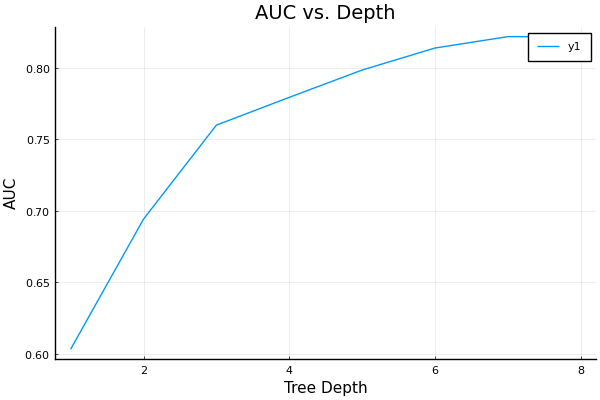

In [64]:
# AUC vs Depth
using Plots
pyplot()

plot(depths,auc_vec,
title = "AUC vs. Depth",
xlabel = "Tree Depth",
ylabel = "AUC")



In [ ]:
### XGBoost ###
XG_boost = IAI.XGBoostClassifier(
    random_seed=1,
    max_categoric_levels_before_warning=100,)

grid_boost = IAI.GridSearch(XG_boost, 
    criterion = :entropy,
    num_round = [20,50,100,150],
    max_depth = 1:3)

IAI.fit_cv!(grid_boost, x_train, y_train, n_folds = 5, validation_criterion = :auc)

XG_boost = IAI.get_learner(grid_boost)

tree_boost_params = IAI.get_params(XG_boost)


auc_boost = IAI.score(grid_boost,x_test, y_test, criterion=:auc)
acc_boost = IAI.score(grid_boost,x_test, y_test, criterion=:accuracy,positive_label =1)
importance_boost = IAI.variable_importance(IAI.get_learner(grid_boost))